In [73]:
import numpy as np
import scipy.signal
import torch
import torchaudio
import librosa
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
waveform, sr = torchaudio.load("01-Evgeniy.wav")
waveform = waveform.mean(dim=0, keepdim=True)
# комментарии добавлю попозже

# Mel-Spectrogram

In [52]:
n_mels = 80
hop_length = 256
n_fft = 1024

mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    power=2.0
)

mel_spec = mel_transform(waveform)

db_transform = T.AmplitudeToDB(stype='power', top_db=80)
mel_spec_db = db_transform(mel_spec)

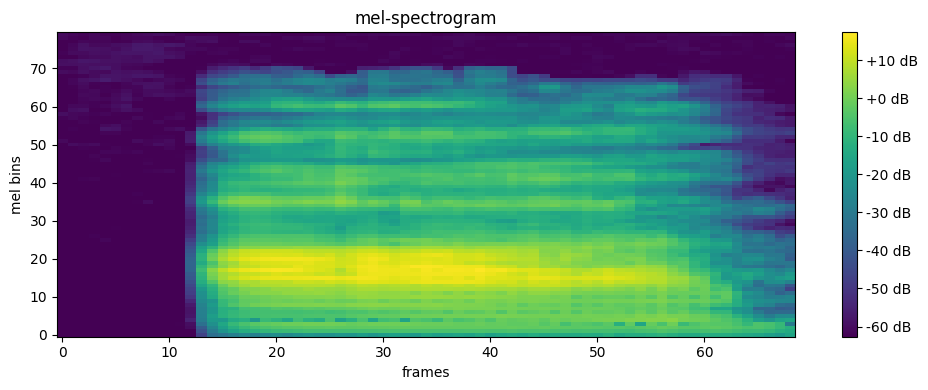

In [53]:
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db[0].numpy(), origin='lower', aspect='auto', interpolation='nearest')
plt.title('mel-spectrogram')
plt.xlabel('frames')
plt.ylabel('mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Pitch (F0)

In [54]:
f0, voiced_flag, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'),
                                  fmax=librosa.note_to_hz('C7'), hop_length=hop_length)
f0 = np.nan_to_num(f0)

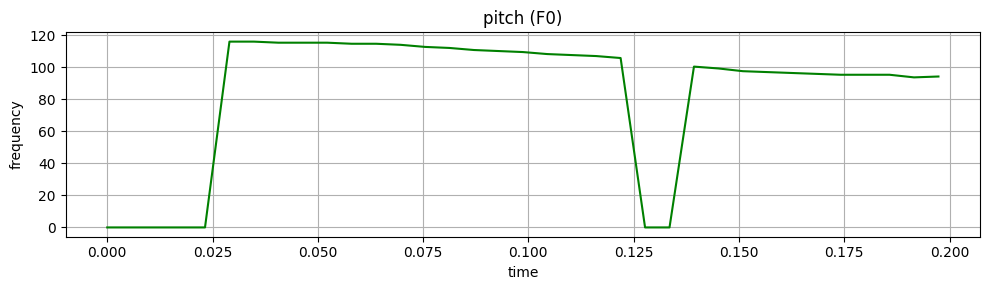

In [55]:
times = librosa.times_like(f0, sr=sr, hop_length=hop_length)

plt.figure(figsize=(10, 3))
plt.plot(times, f0, color='green')
plt.title('pitch (F0)')
plt.ylabel('frequency')
plt.xlabel('time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Energy (RMS)

In [56]:
frame_length = 1024
energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

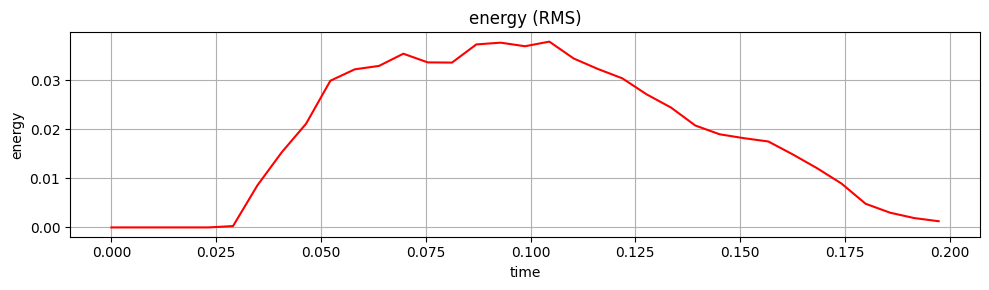

In [57]:
times_energy = librosa.times_like(energy, sr=sr, hop_length=hop_length)

plt.figure(figsize=(10, 3))
plt.plot(times_energy, energy, color='red')
plt.title('energy (RMS)')
plt.ylabel('energy')
plt.xlabel('time')
plt.grid(True)
plt.tight_layout()
plt.show()

# MFCC


In [58]:
n_mfcc = 13
hop_length = 256
n_fft = 1024
n_mels = 80

mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        'n_fft': n_fft,
        'hop_length': hop_length,
        'n_mels': n_mels,
        'power': 2.0
    }
)

mfcc = mfcc_transform(waveform)

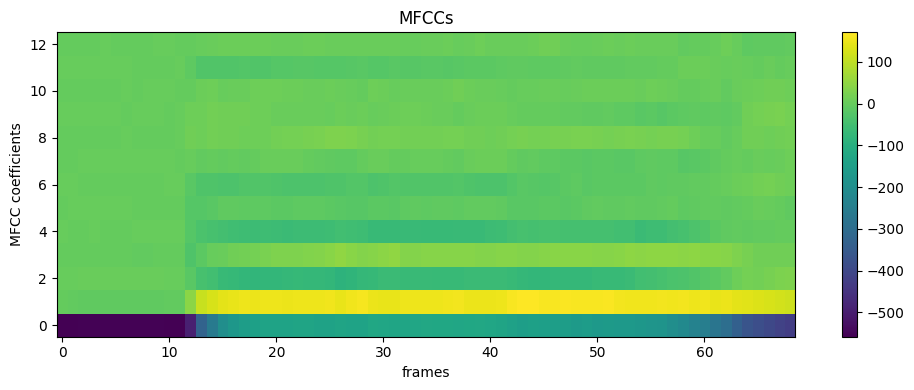

In [59]:
plt.figure(figsize=(10, 4))
plt.imshow(mfcc[0].detach().numpy(), origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('MFCCs')
plt.xlabel('frames')
plt.ylabel('MFCC coefficients')
plt.tight_layout()
plt.show()

# Zero crossing rate

In [70]:
frame_length = 1024
hop_length = 256

if waveform.ndim > 1:
    waveform = waveform.squeeze()

num_samples = waveform.size(0)
target_len = ((num_samples - frame_length) // hop_length + 1) * hop_length + frame_length
pad_len = target_len - num_samples
if pad_len > 0:
    waveform = torch.nn.functional.pad(waveform, (0, pad_len))

frames = waveform.unfold(0, frame_length, hop_length)
num_frames = frames.shape[0]

signs = torch.sign(frames)
sign_changes = torch.abs(signs[:, 1:] - signs[:, :-1])
zero_crossings = torch.sum(sign_changes, dim=1) / 2
zcr = zero_crossings / frame_length

times = torch.arange(num_frames) * hop_length / sr

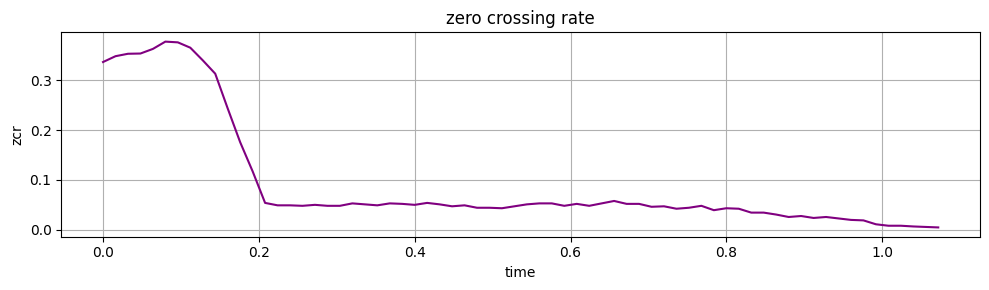

In [71]:
plt.figure(figsize=(10, 3))
plt.plot(times, zcr, color='purple')

plt.title('zero crossing rate')
plt.xlabel('time')
plt.ylabel('zcr')
plt.grid(True)
plt.tight_layout()
plt.show()